# Inference and visualization for DiffAssemble


In [448]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import transforms as mpl_transforms
import seaborn as sns
import numpy as np
import imageio.v2 as imageio


from PIL import Image, ImageFile

In [449]:
from src.model.full_models import *
from src.full_dataset import *
from src.gnn_diffusion import GNN_Diffusion

### 0.- Define functions for visualization

#### 0.1.- Comparative images

In [ ]:
# Wrap helper to add PBC
def wrap_xy(xy, low=-1.0, high=1.0):
    span = high - low
    return (xy - low).remainder(span) + low

# Visualize one denoising step in pose space: [x, y, rot_x, rot_y]
# (consistent with Puzzle_Dataset_ROT + GNN_Diffusion training objective)
def _plot_pose(ax, x_pose, title, cmap_name="tab10"):
    xy = x_pose[:, :2].detach().cpu()
    rot = x_pose[:, 2:4].detach().cpu()
    rot = torch.nn.functional.normalize(rot, dim=1, eps=1e-8)  # stable arrows

    n = xy.shape[0]
    cmap = plt.get_cmap(cmap_name, n)  # one distinct color per patch
    colors = cmap(np.arange(n))

    ax.scatter(xy[:, 0], xy[:, 1], s=18, alpha=0.9, c=colors)
    ax.quiver(
        xy[:, 0], xy[:, 1],
        rot[:, 0], rot[:, 1],
        color=colors,
        angles="xy", scale_units="xy", scale=6, width=0.004, alpha=0.8
    )
    ax.set_xlim(-1.15, 1.15)
    ax.set_ylim(1.15, -1.15)  # image-like orientation
    ax.set_aspect("equal")
    ax.set_title(title)
    ax.grid(alpha=0.25)

In [ ]:
def render_pose_exact(ax, patches, x_pose, title, half_w, half_h, unrotate_input_k=None):
    """
    patches: [N,C,H,W] tensor in [0,1]
    x_pose:  [N,4] -> (x,y,rx,ry), with x,y normalized coordinates
    unrotate_input_k: optional [N] int tensor (e.g. sample.rot_index) to undo dataset-applied discrete rotation first
    """
    xy = x_pose[:, :2].detach().cpu()
    rot = x_pose[:, 2:4].detach().cpu()
    patches = patches.detach().cpu().clamp(0, 1)

    if unrotate_input_k is not None:
        k = unrotate_input_k.detach().cpu().long()
        patches = torch.stack([torch.rot90(p, k=int((-kk.item()) % 4), dims=(1, 2)) for p, kk in zip(patches, k)])

    # exact continuous angle from (rx, ry)
    theta = torch.atan2(rot[:, 1], rot[:, 0]).numpy()  # radians

    valid = torch.isfinite(xy).all(dim=1) & torch.isfinite(torch.tensor(theta))
    xy = xy[valid]
    theta = theta[valid.numpy() if hasattr(valid, "numpy") else valid]
    patches = patches[valid]

    for i in range(patches.shape[0]):
        img = patches[i].permute(1, 2, 0).numpy()
        x, y = float(xy[i, 0]), float(xy[i, 1])

        im = ax.imshow(
            img,
            extent=[x - half_w, x + half_w, y - half_h, y + half_h],
            interpolation="nearest",
            origin="lower",
        )
        im.set_transform(mpl_transforms.Affine2D().rotate_around(x, y, float(theta[i])) + ax.transData)

    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(1.2, -1.2)
    ax.set_aspect("equal")
    ax.set_title(title, color="white")
    ax.axis("off")


def show_triptych_exact(patches, x_start, x_noisy, x0_hat, t=None, unrotate_input_k=None):
    # use clean grid spacing only for visual patch size
    xy0 = x_start[:, :2].detach().cpu()
    xs = torch.sort(torch.unique(xy0[:, 0]))[0]
    ys = torch.sort(torch.unique(xy0[:, 1]))[0]
    dx = float((xs[1] - xs[0]).item()) if len(xs) > 1 else 0.3
    dy = float((ys[1] - ys[0]).item()) if len(ys) > 1 else 0.3
    half_w, half_h = 0.48 * dx, 0.48 * dy

    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    fig.patch.set_facecolor("black")


    render_pose_exact(axs[0], patches, x_start, "Clean x0", half_w, half_h, unrotate_input_k=unrotate_input_k)
    render_pose_exact(axs[1], patches, x_noisy, f"Noisy xt (t={t})" if t is not None else "Noisy xt", half_w, half_h, unrotate_input_k=unrotate_input_k)
    render_pose_exact(axs[2], patches, x0_hat, "Reconstructed x0_hat", half_w, half_h, unrotate_input_k=unrotate_input_k)
    plt.tight_layout()
    plt.savefig("outputs/denoise_triptych.png", dpi=600)
    plt.show()

def show_denoising_exact(patches, traj, t=None, unrotate_input_k=None):
    # use clean grid spacing only for visual patch size
    xy0 = traj[0][:, :2].detach().cpu()
    xs = torch.sort(torch.unique(xy0[:, 0]))[0]
    ys = torch.sort(torch.unique(xy0[:, 1]))[0]
    dx = float((xs[1] - xs[0]).item()) if len(xs) > 1 else 0.3
    dy = float((ys[1] - ys[0]).item()) if len(ys) > 1 else 0.3
    half_w, half_h = 0.48 * dx, 0.48 * dy


    fig, axs = plt.subplots(3, 5, figsize=(12,8))
    fig.patch.set_facecolor("black")
    axs = axs.flatten()
    # hide unused axes in first row
    axs[0].axis('off')
    axs[2].axis('off')
    axs[4].axis('off')


    for i in range(len(axs)):
        if i == 0 or i == 2 or i == 4: 
            continue
        elif i == 1:
            render_pose_exact(axs[i], patches, traj[0], "Clean x0 (target)", half_w, half_h, unrotate_input_k=unrotate_input_k)
        elif i == 3:
            render_pose_exact(axs[i], patches, traj[1], f"Noisy xt (t={int(t[0].item())})", half_w, half_h, unrotate_input_k=unrotate_input_k)
        elif i > 4:
            render_pose_exact(axs[i], patches, traj[(i-4)*10], f"Reverse diffusion step {(i-4)*10}" if i < len(traj) else "Final x0_hat", half_w, half_h, unrotate_input_k=unrotate_input_k)

    plt.tight_layout()
    plt.savefig("outputs/denoise_triptych_traj.png", dpi=600)
    plt.show()



#### 0.2.- Gif

In [452]:
def make_single_step_denoise_gif(x_start, x_noisy, x0_hat, t_value, out_path="outputs/denoise_timeline.gif"):
    os.makedirs("outputs", exist_ok=True)
    frames = []

    # Animation schedule
    hold_clean = 8
    to_noisy = 14
    hold_noisy = 8
    to_denoised = 14
    hold_denoised = 10

    def render_pose_to_frame(x_pose, title):
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        _plot_pose(ax, x_pose, title)  # uses your existing helper from cell 15
        fig.tight_layout()
        fig.canvas.draw()
        frame = np.asarray(fig.canvas.buffer_rgba())[..., :3]
        plt.close(fig)
        return frame

    # 1) clean hold
    for _ in range(hold_clean):
        frames.append(render_pose_to_frame(x_start, "Clean x0"))

    # 2) clean -> noisy
    for a in np.linspace(0, 1, to_noisy):
        x_mid = (1 - a) * x_start + a * x_noisy
        frames.append(render_pose_to_frame(x_mid, f"Noising (t={t_value})"))

    # 3) noisy hold
    for _ in range(hold_noisy):
        frames.append(render_pose_to_frame(x_noisy, f"Noisy xt (t={t_value})"))

    # 4) noisy -> denoised
    for a in np.linspace(0, 1, to_denoised):
        x_mid = (1 - a) * x_noisy + a * x0_hat
        frames.append(render_pose_to_frame(x_mid, "Denoising"))

    # 5) denoised hold
    for _ in range(hold_denoised):
        frames.append(render_pose_to_frame(x0_hat, "Reconstructed x0_hat"))

    imageio.mimsave(out_path, frames, fps=8, loop=0)
    return out_path


In [453]:
def make_single_step_denoise_gif_with_patches(
    patches, x_start, x_noisy, x0_hat, t_value,
    out_path="outputs/denoise_patches.gif",
    unrotate_input_k=None
):
    os.makedirs("outputs", exist_ok=True)

    # Same sizing logic as your triptych
    xy0 = x_start[:, :2].detach().cpu()
    xs = torch.sort(torch.unique(xy0[:, 0]))[0]
    ys = torch.sort(torch.unique(xy0[:, 1]))[0]
    dx = float((xs[1] - xs[0]).item()) if len(xs) > 1 else 0.3
    dy = float((ys[1] - ys[0]).item()) if len(ys) > 1 else 0.3
    half_w, half_h = 0.48 * dx, 0.48 * dy

    frames = []
    hold_clean, to_noisy, hold_noisy, to_denoised, hold_denoised = 8, 14, 8, 14, 10

    def _render_frame(x_pose, title):
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        render_pose_exact(
            ax, patches, x_pose, title, half_w, half_h,
            unrotate_input_k=unrotate_input_k
        )
        fig.patch.set_facecolor("black")
        fig.tight_layout()
        fig.canvas.draw()
        frame = np.asarray(fig.canvas.buffer_rgba())[..., :3]
        plt.close(fig)
        return frame

    # 1) clean hold
    for _ in range(hold_clean):
        frames.append(_render_frame(x_start, "Clean x0"))

    # 2) clean -> noisy
    for a in np.linspace(0, 1, to_noisy):
        x_mid = (1 - a) * x_start + a * x_noisy
        frames.append(_render_frame(x_mid, f"Noising (t={t_value})"))

    # 3) noisy hold
    for _ in range(hold_noisy):
        frames.append(_render_frame(x_noisy, f"Noisy xt (t={t_value})"))

    # 4) noisy -> denoised
    for a in np.linspace(0, 1, to_denoised):
        x_mid = (1 - a) * x_noisy + a * x0_hat
        frames.append(_render_frame(x_mid, "Denoising"))

    # 5) denoised hold
    for _ in range(hold_denoised):
        frames.append(_render_frame(x0_hat, "Reconstructed x0_hat"))

    imageio.mimsave(out_path, frames, fps=8, loop=0)
    return out_path


In [454]:
def make_denoise_gif_traj(
    x_start,
    traj,
    t_values=None,
    out_path="outputs/denoise_timeline.gif",
    fps=10,
    hold_clean=8,
    hold_final=10,
    interp_frames=0,   # set >0 for smoother transitions between steps
):
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    frames = []

    def _to_cpu(x):
        return x.detach().cpu() if torch.is_tensor(x) else torch.as_tensor(x)

    x_start = _to_cpu(x_start)
    traj = [_to_cpu(x) for x in traj]

    if t_values is None:
        # fallback labels: len(traj)-1 ... 0
        t_values = list(range(len(traj) - 1, -1, -1))
    if len(t_values) != len(traj):
        raise ValueError("len(t_values) must match len(traj)")

    def render_pose_to_frame(x_pose, title):
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        _plot_pose(ax, x_pose, title)
        fig.tight_layout()
        fig.canvas.draw()
        frame = np.asarray(fig.canvas.buffer_rgba())[..., :3]
        plt.close(fig)
        return frame

    for _ in range(hold_clean):
        frames.append(render_pose_to_frame(x_start, "Clean x0 (target)"))

    for i in range(len(traj)):
        x_i = traj[i]
        t_i = t_values[i]
        frames.append(render_pose_to_frame(x_i, f"x_t (t={t_i})"))

        if interp_frames > 0 and i < len(traj) - 1:
            x_j = traj[i + 1]
            t_j = t_values[i + 1]
            for a in np.linspace(0, 1, interp_frames + 2)[1:-1]:
                x_mid = (1 - a) * x_i + a * x_j
                frames.append(render_pose_to_frame(x_mid, f"Denoising {t_i}->{t_j}"))

    for _ in range(hold_final):
        frames.append(render_pose_to_frame(traj[-1], "Final x0_hat"))

    imageio.mimsave(out_path, frames, fps=fps, loop=0)
    return out_path


In [455]:
def make_denoise_gif_with_patches_traj(
    patches,
    x_start,
    traj,
    steps=None,
    t_values=None,
    out_path="outputs/denoise_patches_all_steps.gif",
    unrotate_input_k=None,
    fps=10,
    hold_x0=15,
    hold_xt=15,
    hold_final=15,
    step_hold=1,
    interp_frames=0,
    drop_first_if_xstart=True,
):
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)

    x_start = x_start.detach().cpu()
    patches = patches.detach().cpu()
    traj_cpu = [x.detach().cpu() for x in traj]

    # If traj[0] is the input pose, drop it (you already show x_start separately)
    if (
        drop_first_if_xstart
        and len(traj_cpu) > 0
        and torch.allclose(traj_cpu[0], x_start, atol=1e-6, rtol=1e-4)
    ):
        traj_cpu = traj_cpu[1:]

    if len(traj_cpu) == 0:
        raise ValueError("Trajectory is empty after preprocessing.")

    # Build timestep labels
    if t_values is None:
        if steps is None:
            t_values = list(range(len(traj_cpu) - 1, -1, -1))
        else:
            t_values = [max(steps - 1 - i, 0) for i in range(len(traj_cpu))]
    else:
        # If caller passed labels for full traj and we dropped first item, align labels
        if len(t_values) == len(traj) and len(t_values) == len(traj_cpu) + 1:
            t_values = t_values[1:]
        if len(t_values) != len(traj_cpu):
            raise ValueError("len(t_values) must match trajectory length.")

    # Same sizing logic as your triptych/template
    xy0 = x_start[:, :2]
    xs = torch.sort(torch.unique(xy0[:, 0]))[0]
    ys = torch.sort(torch.unique(xy0[:, 1]))[0]
    dx = float((xs[1] - xs[0]).item()) if len(xs) > 1 else 0.3
    dy = float((ys[1] - ys[0]).item()) if len(ys) > 1 else 0.3
    half_w, half_h = 0.48 * dx, 0.48 * dy

    frames = []

    def _render_frame(x_pose, title):
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        render_pose_exact(
            ax, patches, x_pose, title, half_w, half_h, unrotate_input_k=unrotate_input_k
        )
        fig.patch.set_facecolor("black")
        fig.tight_layout()
        fig.canvas.draw()
        frame = np.asarray(fig.canvas.buffer_rgba())[..., :3]
        plt.close(fig)
        return frame

    #Render initial clean pose and hold
    for _ in range(hold_x0):
        frames.append(_render_frame(x_start, "Clean x0"))
        
    # Transition from x0 to xt
    to_first_noisy = 20  # increase for smoother fade
    first_noisy = traj_cpu[0]
    first_t = t_values[0]

    # Render transition from x_start to first noisy step
    for a in np.linspace(0, 1, to_first_noisy + 2)[1:]:
        x_mid = (1 - a) * x_start + a * first_noisy
        frames.append(_render_frame(x_mid, f"Noising (t={first_t})"))
    
    # xt hold (first noisy frame)
    for _ in range(hold_xt):
        frames.append(_render_frame(first_noisy, f"Noisy xt (t={first_t})"))

    # Render each step in trajectory with optional interpolation frames between steps
    for i, (x_t, t) in enumerate(zip(traj_cpu, t_values)):
        for _ in range(step_hold):
            frames.append(_render_frame(x_t, f"x_t (t={t})"))

        if interp_frames > 0 and i < len(traj_cpu) - 1:
            x_next = traj_cpu[i + 1]
            for a in np.linspace(0, 1, interp_frames + 2)[1:-1]:
                x_mid = (1 - a) * x_t + a * x_next
                frames.append(_render_frame(x_mid, f"Denoising {t}->{t_values[i+1]}"))

    # Render final step hold
    for _ in range(hold_final):
        frames.append(_render_frame(traj_cpu[-1], "Final x0_hat"))

    imageio.mimsave(out_path, frames, fps=fps, loop=0)
    return out_path


### 0.- Define paths and steps

In [456]:
dataset_path = os.path.join(os.getcwd(), "data/CelebA-HQ")
print(dataset_path)

steps = 100
dims = 6

/home/mlmcri/Documentos/Courses/2025_2026_AI_course/deep-learning-puzzle-project/data/CelebA-HQ


### 1.- Load test dataset


Test dataset length: 5999
Sample image: 


(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

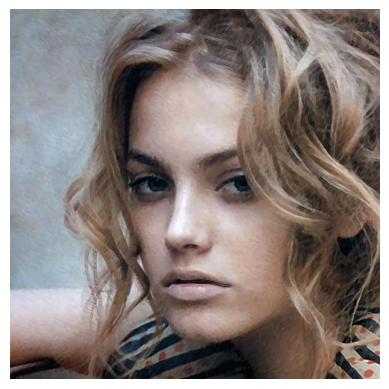

In [457]:
# Load base dataset
test_dataset_base = CelebA_HQ(dataset_path, train=False)
print(f"Test dataset length: {len(test_dataset_base)}")
print(f"Sample image: ")
plt.imshow(test_dataset_base[5812])
plt.axis("off")

In [458]:
# Load puzzle dataset and sample an element
test_puzzle_dt = Puzzle_Dataset(
                        dataset=test_dataset_base,
                        #dataset_get_fn=lambda x: x,
                        patch_per_dim=[(dims,dims)], 
                        augment=False, 
                        degree=-1, 
                        unique_graph=None)

elem = test_puzzle_dt[0]

print(elem)
print(f"X: {elem.x}") # This contains all the node features: x, y, rot1, rot2
print(f"EDGE_INDEX: {elem.edge_index}")
print(f"INDEXES: {elem.indexes}")
# print(f"ROT: {elem.rot}")
# print(f"ROT_INDEX: {elem.rot_index}")
print(f"IND_NAME: {elem.ind_name}")

Data(x=[36, 2], edge_index=[2, 1296], indexes=[36], patches=[36, 3, 32, 32], ind_name=[1], patches_dim=[1, 2])
X: tensor([[-1.0000, -1.0000],
        [-0.6000, -1.0000],
        [-0.2000, -1.0000],
        [ 0.2000, -1.0000],
        [ 0.6000, -1.0000],
        [ 1.0000, -1.0000],
        [-1.0000, -0.6000],
        [-0.6000, -0.6000],
        [-0.2000, -0.6000],
        [ 0.2000, -0.6000],
        [ 0.6000, -0.6000],
        [ 1.0000, -0.6000],
        [-1.0000, -0.2000],
        [-0.6000, -0.2000],
        [-0.2000, -0.2000],
        [ 0.2000, -0.2000],
        [ 0.6000, -0.2000],
        [ 1.0000, -0.2000],
        [-1.0000,  0.2000],
        [-0.6000,  0.2000],
        [-0.2000,  0.2000],
        [ 0.2000,  0.2000],
        [ 0.6000,  0.2000],
        [ 1.0000,  0.2000],
        [-1.0000,  0.6000],
        [-0.6000,  0.6000],
        [-0.2000,  0.6000],
        [ 0.2000,  0.6000],
        [ 0.6000,  0.6000],
        [ 1.0000,  0.6000],
        [-1.0000,  1.0000],
        [-0.6000, 

### Load model with the checkpoint from training

In [459]:
#Load model
model = Eff_GAT(steps=steps,
                input_channels=4,
                output_channels=4,
                n_layers=4,
                model="resnet18equiv",
                architecture="transformer")

# Load model with the checkpoint and set to evaluation mode
checkpoint = torch.load("checkpoints/model_epoch90.pt",
                        weights_only=False,
                        map_location=torch.device("cpu"))

# model.load_state_dict(checkpoint["model_state_dict"])
model.load_state_dict(checkpoint)
model.eval()

print("Model parameters after loading checkpoint:")
for name, param in model.named_parameters():
    print(name, param)


Model parameters after loading checkpoint:
visual_backbone.conv1.weight Parameter containing:
tensor([[[[[ 1.0918e-01, -1.2187e-01, -1.4525e-01],
           [-1.8236e-01, -6.8362e-02, -9.4002e-02],
           [-1.2981e-01, -9.1892e-02, -7.6550e-02]]],


         [[[-4.2245e-02, -7.3820e-02, -4.9891e-02],
           [-8.6846e-02,  8.8763e-02, -6.5765e-02],
           [ 1.9675e-02, -8.0747e-02, -3.5640e-02]]],


         [[[ 8.1142e-02,  1.0025e-01, -1.3930e-01],
           [ 1.5948e-01, -3.9776e-02,  1.7254e-01],
           [ 8.9041e-02,  1.9297e-01, -1.3025e-01]]]],



        [[[[ 7.8668e-02,  1.8853e-01, -6.8619e-02],
           [ 8.0411e-02, -1.4476e-01,  1.3099e-01],
           [-2.0694e-02, -1.5217e-01, -1.9609e-01]]],


         [[[-3.4754e-02,  1.2321e-01, -5.4285e-02],
           [ 2.1256e-02,  1.2185e-01, -2.2396e-02],
           [ 1.3017e-01, -2.5437e-02, -1.9962e-01]]],


         [[[-6.9376e-02, -7.4227e-02, -1.3923e-01],
           [ 2.1155e-01, -4.9970e-02, -5.2503e-03],


### Run inference with a single sample

In [460]:
# Dataloader
batch_size = 1
test_loader = torch_geometric.loader.DataLoader(test_puzzle_dt, 
                                                batch_size=batch_size, 
                                                shuffle=True)

# Get one batch
sample = next(iter(test_loader))

# Add/force "no rotation" feature [1, 0] for every node in the batch
N = sample.x.size(0)  # total nodes across all graphs in batch
rot = torch.zeros(N, 2, dtype=sample.x.dtype, device=sample.x.device)
rot[:, 0] = 1.0

if sample.x.size(1) == 2:
    sample.x = torch.cat([sample.x, rot], dim=1)   # [N,4]
else:
    sample.x[:, 2:4] = rot                        # overwrite existing rot channels

sample.rot = rot
sample.rot_index = torch.zeros(N, dtype=torch.long, device=sample.x.device)

print("x shape:", sample.x.shape)                 # [total_nodes, 4]
print("edge_index shape:", sample.edge_index.shape)
print("indexes shape:", sample.indexes.shape)
print("rot shape:", sample.rot.shape)
print("rot_index shape:", sample.rot_index.shape)
print("ind_name:", sample.ind_name)               # one per graph
print("batch vector shape:", sample.batch.shape)  # node -> graph id
print("num graphs:", int(sample.batch.max().item()) + 1)


x shape: torch.Size([36, 4])
edge_index shape: torch.Size([2, 1296])
indexes shape: torch.Size([36])
rot shape: torch.Size([36, 2])
rot_index shape: torch.Size([36])
ind_name: tensor([2870])
batch vector shape: torch.Size([36])
num graphs: 1


In [461]:
# Load criterion, inference GNN Diffusion class, and run inference step
criterion = torch.nn.functional.smooth_l1_loss
gnn_diffusion = GNN_Diffusion(steps=steps)

if not hasattr(sample, "batch") or sample.batch is None:
    sample.batch = torch.zeros(sample.x.size(0), dtype=torch.long, device=gnn_diffusion.device)

# Run inference step
with torch.no_grad():
    num_graphs = int(sample.batch.max().item()) + 1
    t_graph = torch.Tensor([range(gnn_diffusion.steps)[-1]], device=gnn_diffusion.device).long()
    time = torch.gather(t_graph, 0, sample.batch)

    x_start = sample.x
    noise = torch.randn_like(x_start)
    x_noisy = gnn_diffusion.q_sample(x_start=x_start, t=time, noise=noise)

    patch_feats = model.visual_features(sample.patches)
    pred_noise, _ = model.forward_with_feats(
        x_noisy, time, sample.patches, sample.edge_index, patch_feats, sample.batch
    )

    # Reconstruct denoised x0 estimate from epsilon prediction
    sqrt_ab = gnn_diffusion.sqrt_alphas_cumprod.to(gnn_diffusion.device)[time].unsqueeze(-1)
    sqrt_1mab = gnn_diffusion.sqrt_one_minus_alphas_cumprod.to(gnn_diffusion.device)[time].unsqueeze(-1)
    x0_hat = (x_noisy - sqrt_1mab * pred_noise) / (sqrt_ab + 1e-8)

    loss = criterion(noise, pred_noise).item()

print(f"Sample loss: {loss}")


Sample loss: 0.009558000601828098


###  Full step-wise inference

In [462]:
# Stepwise reverse diffusion inference (100 steps)
model.eval()

# Load criterion, inference GNN Diffusion class, and run inference step
criterion = torch.nn.functional.smooth_l1_loss
gnn_diffusion = GNN_Diffusion(steps=steps)

# Prepare sample
sample = sample.to(gnn_diffusion.device)
if not hasattr(sample, "batch") or sample.batch is None:
    sample.batch = torch.zeros(sample.x.size(0), dtype=torch.long, device=gnn_diffusion.device)

num_graphs = int(sample.batch.max().item()) + 1

# same schedule as in GNN_Diffusion
betas = torch.linspace(1e-4, 2e-2, steps, device=gnn_diffusion.device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

with torch.no_grad():
    patch_feats = model.visual_features(sample.patches)

    # start from pure noise (inference)
    x_t = torch.randn_like(sample.x)

    traj = [sample.x, x_t.detach().cpu()]  # Save intermediate states for visualization (initialize with clean x0 and noisy xt)
    t_values = [None, steps-1]

    for t_scalar in reversed(range(steps)):  # 99, 98, ..., 0
        t_graph = torch.full((num_graphs,), t_scalar, device=gnn_diffusion.device, dtype=torch.long)
        t = t_graph[sample.batch]  # node-level timestep

        pred_noise, _ = model.forward_with_feats(
            x_t, t, sample.patches, sample.edge_index, patch_feats, sample.batch
        )

        a_t = alphas[t].unsqueeze(-1)
        ab_t = alphas_cumprod[t].unsqueeze(-1)
        b_t = betas[t].unsqueeze(-1)

        z = torch.randn_like(x_t) if t_scalar > 0 else torch.zeros_like(x_t)

        # DDPM reverse step: x_t -> x_{t-1}
        x_t = (1.0 / torch.sqrt(a_t)) * (
            x_t - ((1.0 - a_t) / torch.sqrt(1.0 - ab_t + 1e-8)) * pred_noise
        ) + torch.sqrt(b_t) * z


        traj.append(x_t.detach().cpu())
        t_values.append(max(t_scalar-1, 0))

x0_hat = x_t
print("Done. Final sample shape:", x0_hat.shape)


Done. Final sample shape: torch.Size([36, 4])


### Visualization

#### Vectors

10
20
30
40
50
60
70
80
90
100


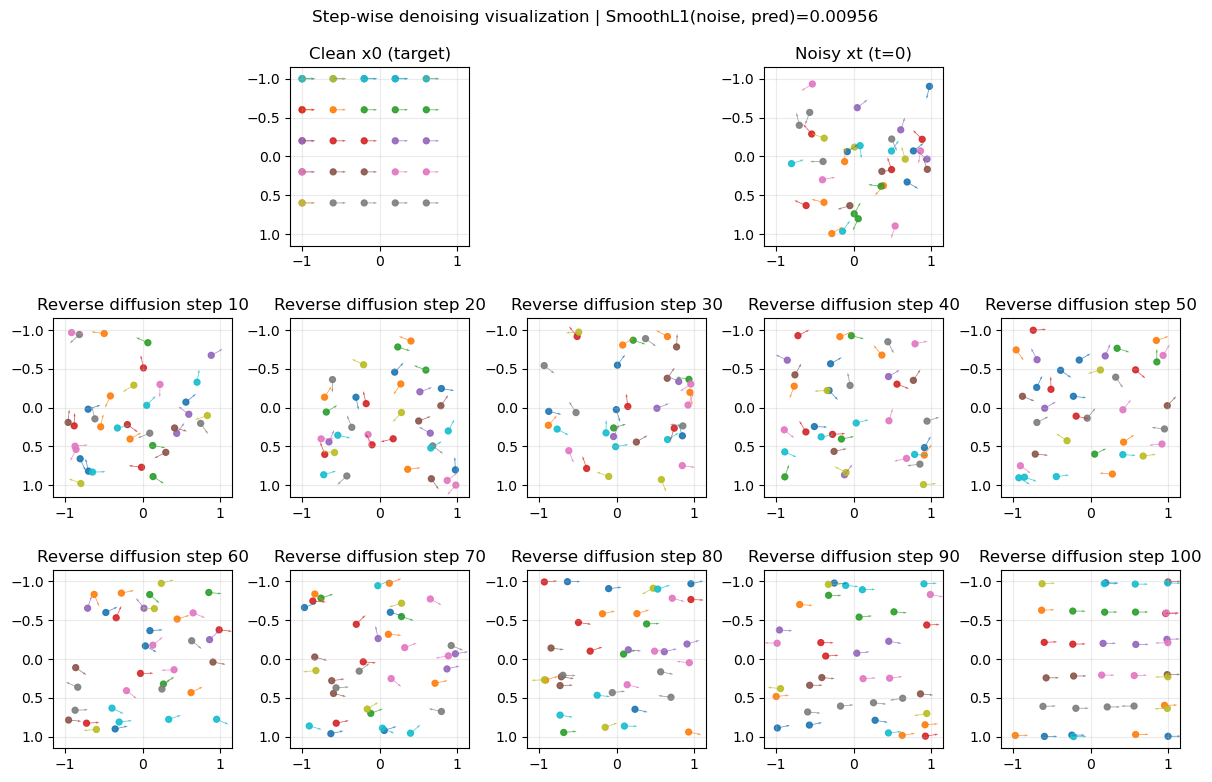

In [463]:
fig, axs = plt.subplots(3, 5, figsize=(12,8))
axs = axs.flatten()
# hide unused axes in first row
axs[0].axis('off')
axs[2].axis('off')
axs[4].axis('off')


for i in range(len(axs)):
    if i == 0 or i == 2 or i == 4: 
        continue
    elif i == 1:
        _plot_pose(axs[i], traj[0], "Clean x0 (target)")
    elif i == 3:
        _plot_pose(axs[i], traj[1], f"Noisy xt (t={int(t[0].item())})")
    elif i > 4:
        print((i-4)*10)
        _plot_pose(axs[i], traj[(i-4)*10], f"Reverse diffusion step {(i-4)*10}" if i < len(traj) else "Final x0_hat")
fig.suptitle(f"Step-wise denoising visualization | SmoothL1(noise, pred)={loss:.5f}")
plt.tight_layout()
plt.savefig("outputs/denoise_arrows_traj.png", dpi=600)
plt.show()

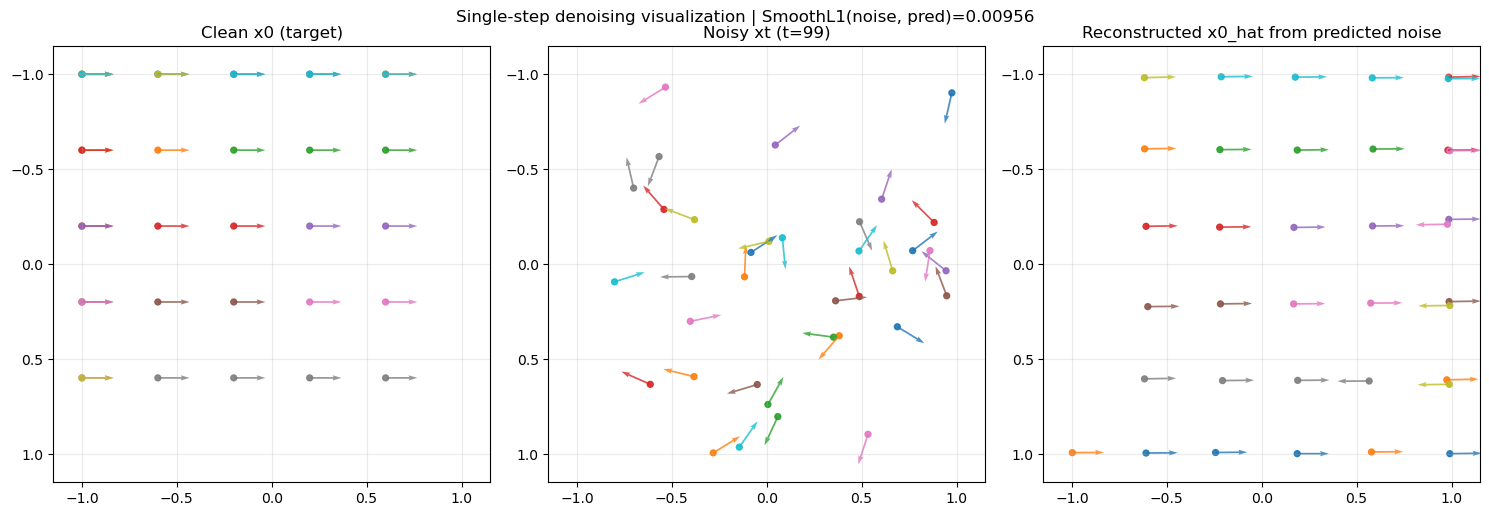

In [464]:
# Plot 
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
_plot_pose(axs[0], traj[0], "Clean x0 (target)")
_plot_pose(axs[1], traj[1], f"Noisy xt (t={int(time[0].item())})")
_plot_pose(axs[2], traj[-1], "Reconstructed x0_hat from predicted noise")
fig.suptitle(f"Single-step denoising visualization | SmoothL1(noise, pred)={loss:.5f}")
plt.tight_layout()
plt.savefig("outputs/denoise_arrows.png", dpi=600)
plt.show()


#### Patches

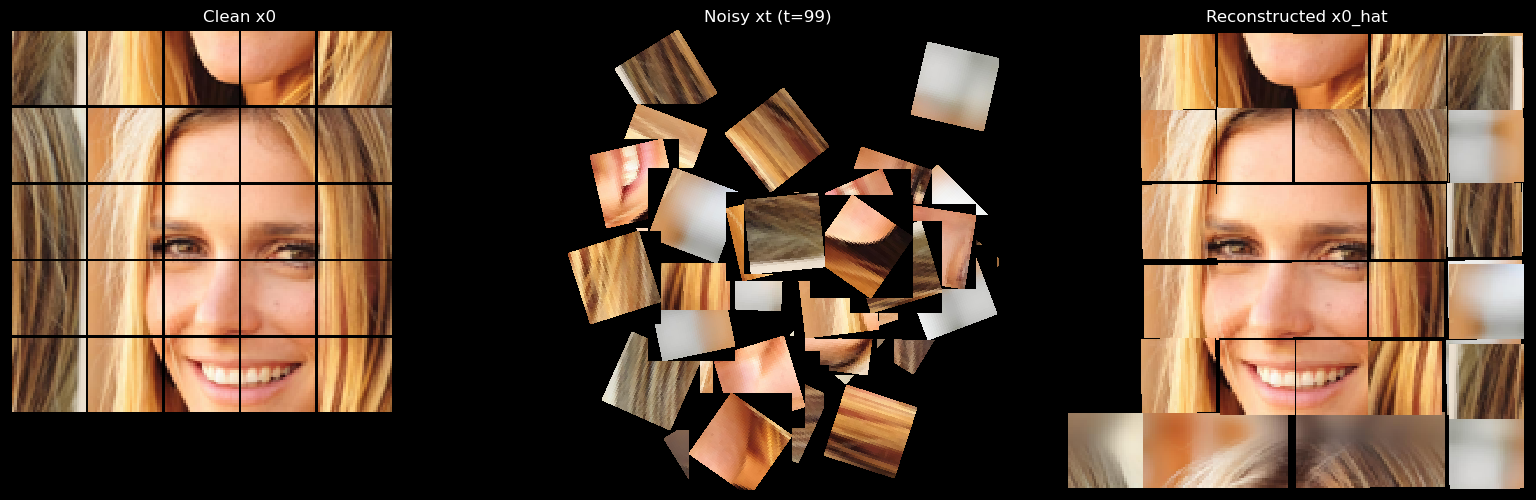

In [465]:
show_triptych_exact(
    sample.patches, traj[0], traj[1], traj[-1],
    t=int(time[0].item()),
    unrotate_input_k=None  # set to None if not using Puzzle_Dataset_ROT
)


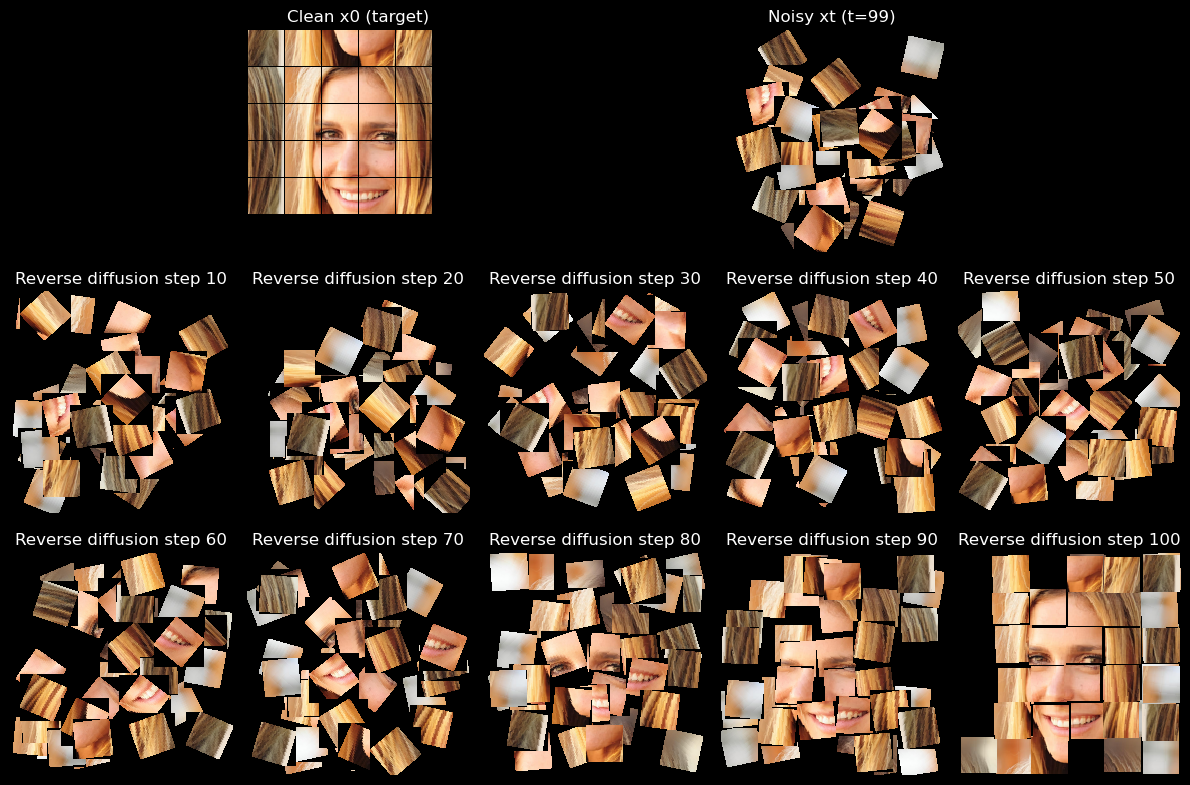

In [466]:
show_denoising_exact(    
    sample.patches, traj,
    t=time,
    unrotate_input_k=None  # set to None if not using Puzzle_Dataset_ROT
)

### Animation?

In [467]:
gif_path = make_single_step_denoise_gif(
    x_start.detach().cpu(),
    x_noisy.detach().cpu(),
    x0_hat.detach().cpu(),
    t_value=int(t[0].item()),
)
print("Saved:", gif_path)
gif_path = make_single_step_denoise_gif_with_patches(
    patches=sample.patches.detach().cpu(),
    x_start=x_start.detach().cpu(),
    x_noisy=x_noisy.detach().cpu(),
    x0_hat=x0_hat.detach().cpu(),
    t_value=int(t[0].item()),
    # unrotate_input_k=sample_viz.rot_index.detach().cpu()  # optional
)
print("Saved:", gif_path)


Saved: outputs/denoise_timeline.gif
Saved: outputs/denoise_patches.gif


In [ ]:
gif_path = make_denoise_gif_traj(
    x_start=x_start.detach().cpu(),
    traj=traj,
    t_values=t_values,
    out_path="outputs/denoise_all_steps.gif",
    fps=8,
    interp_frames=0,
)

gif_path = make_denoise_gif_with_patches_traj(
    patches=sample.patches,
    x_start=x_start,
    traj=traj,            # all intermediate states
    steps=steps,          # e.g. 100
    out_path="outputs/denoise_patches_all_steps.gif",
    unrotate_input_k=None,
)
print("Saved:", gif_path)
